In [ ]:
%pip install -r requirements.txt

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from gensim.models import KeyedVectors
import warnings
warnings.filterwarnings('ignore')
import gensim.downloader as api

In [20]:
model = api.load("word2vec-google-news-300")

In [34]:
plt.style.use('default')
sns.set_palette("husl")
sns.set_context("notebook", font_scale=1.1)

## 1. Analysing Occupational Stereotypes

In [21]:
male_pronouns = ['he', 'him', 'his', 'man', 'male']
female_pronouns = ['she', 'her', 'hers', 'woman', 'female']

In [22]:
# Occupations from Bolukbasi et al. (2016) - "Man is to Computer Programmer as Woman is to Homemaker?"
extreme_she_occupations = [
    'homemaker', 'nurse', 'receptionist', 'librarian', 'socialite', 
    'hairdresser', 'nanny', 'bookkeeper', 'stylist', 'housekeeper', 
    'interior_designer', 'guidance_counselor'
]

extreme_he_occupations = [
    'maestro', 'skipper', 'protege', 'philosopher', 'captain', 
    'architect', 'financier', 'warrior', 'broadcaster', 'magician', 
    'fighter_pilot', 'boss'
]

all_occupations = extreme_she_occupations + extreme_he_occupations

In [23]:
def cosine_similarity(vec1, vec2):
    """Calculate cosine similarity between two vectors"""
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

def calculate_gender_bias_score(model, word):
    """
    Calculate gender bias score for a word
    Positive = more male-associated, Negative = more female-associated
    """
    if word not in model:
        return None
    
    word_vec = model[word]
    
    # Calculate average similarity with male pronouns
    male_similarities = []
    for pronoun in male_pronouns:
        if pronoun in model:
            male_similarities.append(cosine_similarity(word_vec, model[pronoun]))
    
    # Calculate average similarity with female pronouns  
    female_similarities = []
    for pronoun in female_pronouns:
        if pronoun in model:
            female_similarities.append(cosine_similarity(word_vec, model[pronoun]))
    
    if not male_similarities or not female_similarities:
        return None
        
    male_avg = np.mean(male_similarities)
    female_avg = np.mean(female_similarities)
    
    return male_avg - female_avg


In [24]:
def analyze_occupational_bias(model):
    """Analyze gender bias across occupations"""
    results = []
    
    for occupation in all_occupations:
        bias_score = calculate_gender_bias_score(model, occupation)
        
        if bias_score is not None:
            # Determine category based on Bolukbasi et al. (2016)
            if occupation in extreme_he_occupations:
                category = 'Extreme He'
            elif occupation in extreme_she_occupations:
                category = 'Extreme She'
            else:
                category = 'Other'
                
            results.append({
                'occupation': occupation,
                'bias_score': bias_score,
                'category': category
            })
    
    return pd.DataFrame(results)

In [30]:
def plot_occupation_bias(df, ax):
    """Create visualization of occupational bias using ax"""
    colors = {'Extreme He': 'blue', 'Extreme She': 'red', 'Other': 'green'}
    handled = set()

    for category in df['category'].unique():
        subset = df[df['category'] == category]
        label = category if category not in handled else None
        ax.scatter(subset.index, subset['bias_score'],
                   color=colors[category], label=label, alpha=0.7, s=60)
        handled.add(category)
        
        for idx, row in subset.iterrows():
            ax.annotate(row['occupation'],
                        (idx, row['bias_score']),
                        xytext=(5, 5), textcoords='offset points',
                        fontsize=8, alpha=0.8)

    ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax.set_xlabel('Occupation Index')
    ax.set_ylabel('Gender Bias Score (Male+ / Female−)')
    ax.set_title('Gender Bias in Occupational Word Embeddings')
    ax.legend()
    ax.grid(True, alpha=0.3)


In [ ]:
def create_2d_visualization():
    """Create 2D visualization using PCA"""

    words_to_plot = all_occupations + male_pronouns + female_pronouns
    
    # Filter words that exist in model
    available_words = [word for word in words_to_plot if word in model]
    
    # Get word vectors
    vectors = np.array([model[word] for word in available_words])
    
    # Apply PCA
    pca = PCA(n_components=2)
    vectors_2d = pca.fit_transform(vectors)
    
    plot_df = pd.DataFrame({
        'word': available_words,
        'x': vectors_2d[:, 0],
        'y': vectors_2d[:, 1]
    })
    
    # Add categories
    def get_word_category(word):
        if word in male_pronouns:
            return 'Male Pronouns'
        elif word in female_pronouns:
            return 'Female Pronouns'
        elif word in extreme_he_occupations:
            return 'Extreme He Occupations'
        elif word in extreme_she_occupations:
            return 'Extreme She Occupations'
        else:
            return 'Other'
    
    plot_df['category'] = plot_df['word'].apply(get_word_category)
    

    plt.figure(figsize=(12, 8))
    colors = {
        'Male Pronouns': 'darkblue',
        'Female Pronouns': 'darkred', 
        'Extreme He Occupations': 'lightblue',
        'Extreme She Occupations': 'lightcoral',
        'Other': 'lightgreen'
    }
    
    for category in plot_df['category'].unique():
        subset = plot_df[plot_df['category'] == category]
        plt.scatter(subset['x'], subset['y'], 
                   c=colors[category], label=category, 
                   alpha=0.7, s=60)
        
        # Add word labels
        for _, row in subset.iterrows():
            plt.annotate(row['word'], 
                        (row['x'], row['y']),
                        xytext=(5, 5), textcoords='offset points',
                        fontsize=8, alpha=0.8)
    
    plt.xlabel(f'PC1 (Variance: {pca.explained_variance_ratio_[0]:.2%})')
    plt.ylabel(f'PC2 (Variance: {pca.explained_variance_ratio_[1]:.2%})')
    plt.title('2D Visualization of Gender and Occupational Terms')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


In [27]:
def print_bias_summary(df):    
    print("Summary Statistics:")
    print(df.groupby('category')['bias_score'].agg(['mean', 'std', 'count']).round(4))
    print()
    
    print("Most Male-Biased Occupations:")
    print(df.nlargest(5, 'bias_score')[['occupation', 'bias_score']].to_string(index=False))
    print()
    
    print("Most Female-Biased Occupations:")
    print(df.nsmallest(5, 'bias_score')[['occupation', 'bias_score']].to_string(index=False))
    print()
    
    print("Expected vs Actual Bias Direction:")
    he_avg = df[df['category'] == 'Extreme He']['bias_score'].mean()
    she_avg = df[df['category'] == 'Extreme She']['bias_score'].mean()
    
    print(f"Extreme He Occupations Average Bias: {he_avg:.4f}")
    print(f"Extreme She Occupations Average Bias: {she_avg:.4f}")
    print(f"Expected: He > 0, She < 0. Actual difference: {he_avg - she_avg:.4f}")

In [32]:
def run_occupational_analysis(model):
    """Run complete occupational bias analysis"""
    
    # Analyze bias
    bias_df = analyze_occupational_bias(model)
    
    # Print summary
    print_bias_summary(bias_df)

    fig, (ax1, ax2) = plt.subplots(1,2,figsize = (14,6))
    
    # Create visualizations
    plot_occupation_bias(bias_df, ax1)
    create_2d_visualization(ax2)
    
    plt.tight_layout()
    plt.show()
    
    return bias_df

Summary Statistics:
               mean     std  count
category                          
Extreme He   0.1122  0.0316     12
Extreme She -0.1552  0.0268     12

Most Male-Biased Occupations:
occupation  bias_score
   maestro    0.181312
   skipper    0.149555
   protege    0.125422
  magician    0.123095
   captain    0.117019

Most Female-Biased Occupations:
  occupation  bias_score
   homemaker   -0.205187
       nurse   -0.179114
receptionist   -0.173008
 hairdresser   -0.166565
   socialite   -0.164414

Expected vs Actual Bias Direction:
Extreme He Occupations Average Bias: 0.1122
Extreme She Occupations Average Bias: -0.1552
Expected: He > 0, She < 0. Actual difference: 0.2675


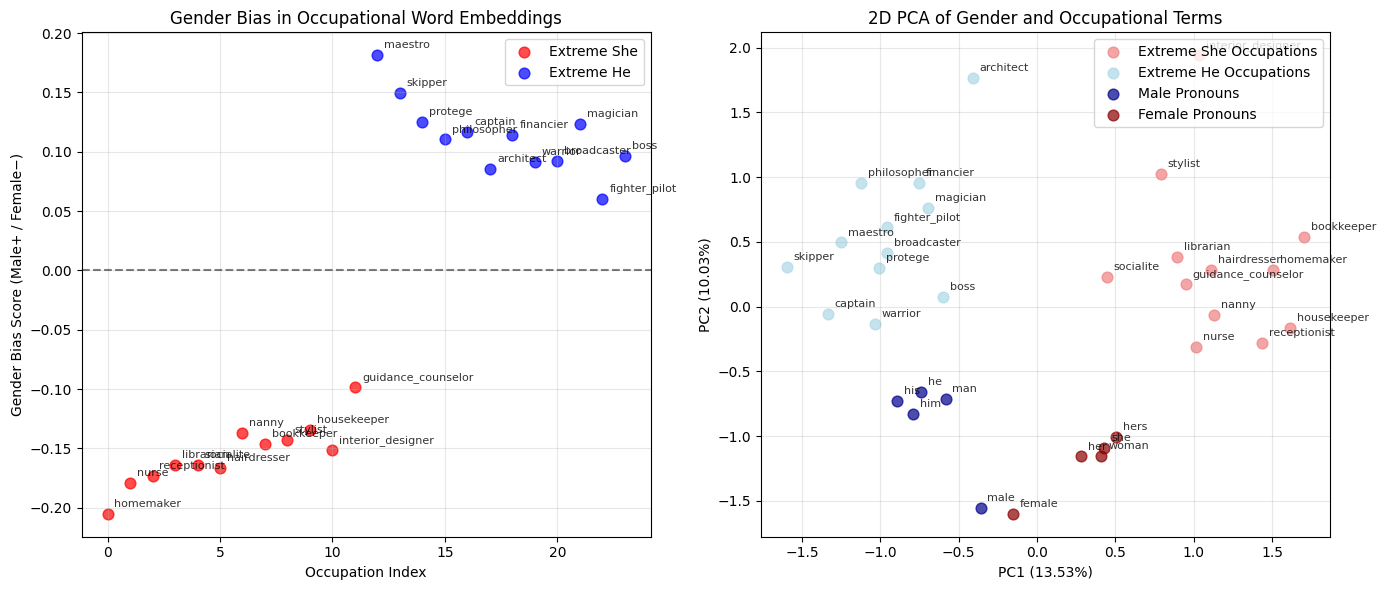

In [33]:
results = run_occupational_analysis(model)

The summary statistics reveal a clear pattern of gender bias in word embeddings. Occupations traditionally viewed as male are more closely associated with male pronouns, while female-associated occupations show stronger similarity to female pronouns. This alignment with societal stereotypes demonstrates that Word2Vec embeddings reflect and reinforce existing gender biases.

While the gender bias scores reveal individual occupation associations with gender terms, they don't provide statistical validation. We now use WEAT to rigorously test whether these patterns represent statistically significant gender stereotypes in the embedding space.**

In [35]:
# Word sets from Bolukbasi et al. (2016)
male_names = [
    'john', 'paul', 'mike', 'kevin', 'steve', 'greg', 'jeff', 'bill',
    'matthew', 'joshua', 'david', 'james', 'robert', 'richard', 'charles'
]

female_names = [
    'amy', 'joan', 'lisa', 'sarah', 'diana', 'kate', 'ann', 'donna',
    'jennifer', 'michelle', 'stephanie', 'amanda', 'rachel', 'susan', 'mary'
]

In [57]:
def get_word_vectors(model, word_list):
    """Get vectors for words that exist in the model"""
    vectors = []    
    for word in word_list:
        if word in model:
            vectors.append(model[word])
    
    return np.array(vectors)

In [37]:
def calculate_association_strength(target_vec, attribute_vecs):
    """Calculate average cosine similarity between target and attribute vectors"""
    similarities = [cosine_similarity(target_vec, attr_vec) for attr_vec in attribute_vecs]
    return np.mean(similarities)

def single_word_association_test(target_vec, attr_A_vecs, attr_B_vecs):
    """Calculate s(w, A, B) = mean_cos(w, A) - mean_cos(w, B)"""
    assoc_A = calculate_association_strength(target_vec, attr_A_vecs)
    assoc_B = calculate_association_strength(target_vec, attr_B_vecs)
    return assoc_A - assoc_B

def weat_effect_size(target_X_vecs, target_Y_vecs, attr_A_vecs, attr_B_vecs):
    """Calculate WEAT effect size d"""
    # Calculate s(w, A, B) for all words in target sets
    X_associations = [single_word_association_test(vec, attr_A_vecs, attr_B_vecs) 
                     for vec in target_X_vecs]
    Y_associations = [single_word_association_test(vec, attr_A_vecs, attr_B_vecs) 
                     for vec in target_Y_vecs]
    
    # Calculate effect size
    X_mean = np.mean(X_associations)
    Y_mean = np.mean(Y_associations)
    
    # Pooled standard deviation
    all_associations = X_associations + Y_associations
    pooled_std = np.std(all_associations, ddof=1)
    
    effect_size = (X_mean - Y_mean) / pooled_std
    
    return effect_size, X_associations, Y_associations

In [38]:
def weat_permutation_test(target_X_vecs, target_Y_vecs, attr_A_vecs, attr_B_vecs, 
                         n_permutations=10000):
    """Perform permutation test for WEAT statistical significance"""
    
    # Calculate original effect size
    original_effect, X_assoc, Y_assoc = weat_effect_size(target_X_vecs, target_Y_vecs, 
                                                        attr_A_vecs, attr_B_vecs)
    
    # Combine all target vectors for permutation
    all_target_vecs = np.vstack([target_X_vecs, target_Y_vecs])
    X_size = len(target_X_vecs)
    
    # Permutation test
    permuted_effects = []
    for _ in range(n_permutations):
        # Randomly shuffle target assignments
        perm_indices = np.random.permutation(len(all_target_vecs))
        perm_X_vecs = all_target_vecs[perm_indices[:X_size]]
        perm_Y_vecs = all_target_vecs[perm_indices[X_size:]]
        
        # Calculate effect size for permuted data
        perm_effect, _, _ = weat_effect_size(perm_X_vecs, perm_Y_vecs, 
                                           attr_A_vecs, attr_B_vecs)
        permuted_effects.append(perm_effect)
    
    # Calculate p-value
    p_value = np.mean(np.abs(permuted_effects) >= np.abs(original_effect))
    
    return original_effect, p_value, permuted_effects, X_assoc, Y_assoc

In [ ]:
def weat_permutation_test(target_X_vecs, target_Y_vecs, attr_A_vecs, attr_B_vecs, 
                         n_permutations=10000):
    """Perform permutation test for WEAT statistical significance"""
    
    # Calculate original effect size
    original_effect, X_assoc, Y_assoc = weat_effect_size(target_X_vecs, target_Y_vecs, 
                                                        attr_A_vecs, attr_B_vecs)
    
    # Combine all target vectors for permutation
    all_target_vecs = np.vstack([target_X_vecs, target_Y_vecs])
    X_size = len(target_X_vecs)
    
    # Permutation test
    permuted_effects = []
    for _ in range(n_permutations):
        # Randomly shuffle target assignments
        perm_indices = np.random.permutation(len(all_target_vecs))
        perm_X_vecs = all_target_vecs[perm_indices[:X_size]]
        perm_Y_vecs = all_target_vecs[perm_indices[X_size:]]
        
        # Calculate effect size for permuted data
        perm_effect, _, _ = weat_effect_size(perm_X_vecs, perm_Y_vecs, 
                                           attr_A_vecs, attr_B_vecs)
        permuted_effects.append(perm_effect)
    
    # Calculate p-value
    p_value = np.mean(np.abs(permuted_effects) >= np.abs(original_effect))
    
    return original_effect, p_value, permuted_effects, X_assoc, Y_assoc

def run_occupational_weat(model):
    # Get word vectors
    male_vecs = get_word_vectors(model, male_names)
    female_vecs = get_word_vectors(model, female_names)
    he_occ_vecs = get_word_vectors(model, extreme_he_occupations)
    she_occ_vecs = get_word_vectors(model, extreme_she_occupations)   
  
    # # Run WEAT test: Male names vs Female names with He-occupations vs She-occupations
    # print("WEAT Test: Male/Female Names × Extreme He/She Occupations")
    # print("H0: No association between gender names and gendered occupational stereotypes")
    # print("H1: Male names more associated with 'he' occupations, female names with 'she' occupations\n")
    
    effect_size, p_value, permuted_effects, male_assoc, female_assoc = weat_permutation_test(
        male_vecs, female_vecs, he_occ_vecs, she_occ_vecs
    )
    
    print(f"Effect Size (d): {effect_size:.4f}")
    print(f"P-value: {p_value:.6f}")
    print(f"Statistical significance: {'Yes' if p_value < 0.05 else 'No'} (α = 0.05)")
    
    # Cohen's d interpretation
    if abs(effect_size) < 0.2:
        magnitude = "negligible"
    elif abs(effect_size) < 0.5:
        magnitude = "small"
    elif abs(effect_size) < 0.8:
        magnitude = "medium"
    else:
        magnitude = "large"
    
    print(f"Effect size magnitude: {magnitude}")
    
    # Interpretation
    if effect_size > 0:
        print(f"\nResult: Male names are more associated with 'he' occupations")
        print(f"        Female names are more associated with 'she' occupations")
        print(f"        → Confirms occupational gender stereotypes in embeddings")
    else:
        print(f"\nResult: Female names are more associated with 'he' occupations")
        print(f"        Male names are more associated with 'she' occupations")
        print(f"        → Counter-stereotypical associations found")
    
    return {
        'effect_size': effect_size,
        'p_value': p_value,
        'permuted_effects': permuted_effects,
        'male_associations': male_assoc,
        'female_associations': female_assoc,
    }

In [40]:
def run_occupation_weat_analysis(model):
    """Run complete occupational WEAT analysis with enhanced visualizations"""    
    weat_results = run_occupational_weat(model)
    
    if weat_results is None:
        return None
    
    # # Create enhanced visualizations
    # plot_weat_permutation_results(weat_results)
    
    # # Create similarity heatmap
    # sim_df = create_occupation_similarity_heatmap(model)
    
    # # Analyze individual associations
    # individual_df = analyze_individual_associations(model)
    # if individual_df is not None:
    #     plot_individual_associations(individual_df)
    
    return {
        'weat_results': weat_results,
        # 'similarity_matrix': sim_df,
        # 'individual_associations': individual_df
    }

# Example usage:
# model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
results = run_occupation_weat_analysis(model)

Gender bias scores provide exploratory analysis of individual word associations
but lack statistical rigor. To formally test whether systematic gender stereotypes
exist in the embeddings, we now employ WEAT with significance testing.

Valid words found:
Male names: 15/15 - ['john', 'paul', 'mike', 'kevin', 'steve', 'greg', 'jeff', 'bill', 'matthew', 'joshua', 'david', 'james', 'robert', 'richard', 'charles']
Female names: 15/15 - ['amy', 'joan', 'lisa', 'sarah', 'diana', 'kate', 'ann', 'donna', 'jennifer', 'michelle', 'stephanie', 'amanda', 'rachel', 'susan', 'mary']
'He' occupations: 12/12 - ['maestro', 'skipper', 'protege', 'philosopher', 'captain', 'architect', 'financier', 'warrior', 'broadcaster', 'magician', 'fighter_pilot', 'boss']
'She' occupations: 12/12 - ['homemaker', 'nurse', 'receptionist', 'librarian', 'socialite', 'hairdresser', 'nanny', 'bookkeeper', 'stylist', 'housekeeper', 'interior_designer', 'guidance_counselor']

WEAT Test: Male/Female Names × Extreme He/She Occup

In [ ]:
def plot_weat_permutation_results(weat_results):
    """Visualize WEAT permutation test and association score distributions."""
    if weat_results is None:
        return

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # --- Plot 1: Permutation distribution ---
    permuted_effects = weat_results['permuted_effects']
    observed_effect = weat_results['effect_size']
    p_value = weat_results['p_value']

    n, bins, patches = ax1.hist(permuted_effects, bins=50, alpha=0.7,
                                color='lightsteelblue', edgecolor='navy',
                                linewidth=0.5, density=True)

    for i, patch in enumerate(patches):
        if bins[i] <= -abs(observed_effect) or bins[i] >= abs(observed_effect):
            patch.set_facecolor('lightcoral')
            patch.set_alpha(0.8)

    ax1.axvline(observed_effect, color='red', linestyle='--', linewidth=3,
                label=f'Observed Effect: {observed_effect:.3f}')
    ax1.axvline(-observed_effect, color='red', linestyle='--', linewidth=2, alpha=0.7)
    ax1.axvline(0, color='black', linestyle='-', alpha=0.5, linewidth=1)

    ax1.set_xlabel('Effect Size (d)', fontweight='bold')
    ax1.set_ylabel('Density', fontweight='bold')
    ax1.set_title(f'Permutation Test Distribution\n(p = {p_value:.4f})', fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)

    # Optional text box
    textstr = f'n_permutations = {len(permuted_effects):,}\nα = 0.05\n'
    textstr += f'Significant: {"Yes" if p_value < 0.05 else "No"}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    ax1.text(0.02, 0.98, textstr, transform=ax1.transAxes, fontsize=9,
             verticalalignment='top', bbox=props)

    # --- Plot 2: Violin plot for association scores ---
    male_assoc = weat_results['male_associations']
    female_assoc = weat_results['female_associations']

    data_for_violin = pd.DataFrame({
        'Association Score': male_assoc + female_assoc,
        'Gender': ['Male Names'] * len(male_assoc) + ['Female Names'] * len(female_assoc)
    })

    sns.violinplot(data=data_for_violin, x='Gender', y='Association Score', ax=ax2,
                   palette=['lightblue', 'lightcoral'], inner='box')
    
    ax2.axhline(0, color='black', linestyle='--', alpha=0.5)
    ax2.set_title('Association Score Distributions', fontweight='bold')
    ax2.set_ylabel('s(w, He-Occ, She-Occ)', fontweight='bold')
    ax2.grid(True, alpha=0.3)

    # Mean lines
    male_mean = np.mean(male_assoc)
    female_mean = np.mean(female_assoc)
    ax2.hlines(male_mean, -0.4, 0.4, colors='blue', linewidth=2, alpha=0.8)
    ax2.hlines(female_mean, 0.6, 1.4, colors='red', linewidth=2, alpha=0.8)
    ax2.text(0, male_mean + 0.01, f'μ = {male_mean:.3f}', ha='center', fontweight='bold')
    ax2.text(1, female_mean + 0.01, f'μ = {female_mean:.3f}', ha='center', fontweight='bold')

    plt.tight_layout()
    plt.show()

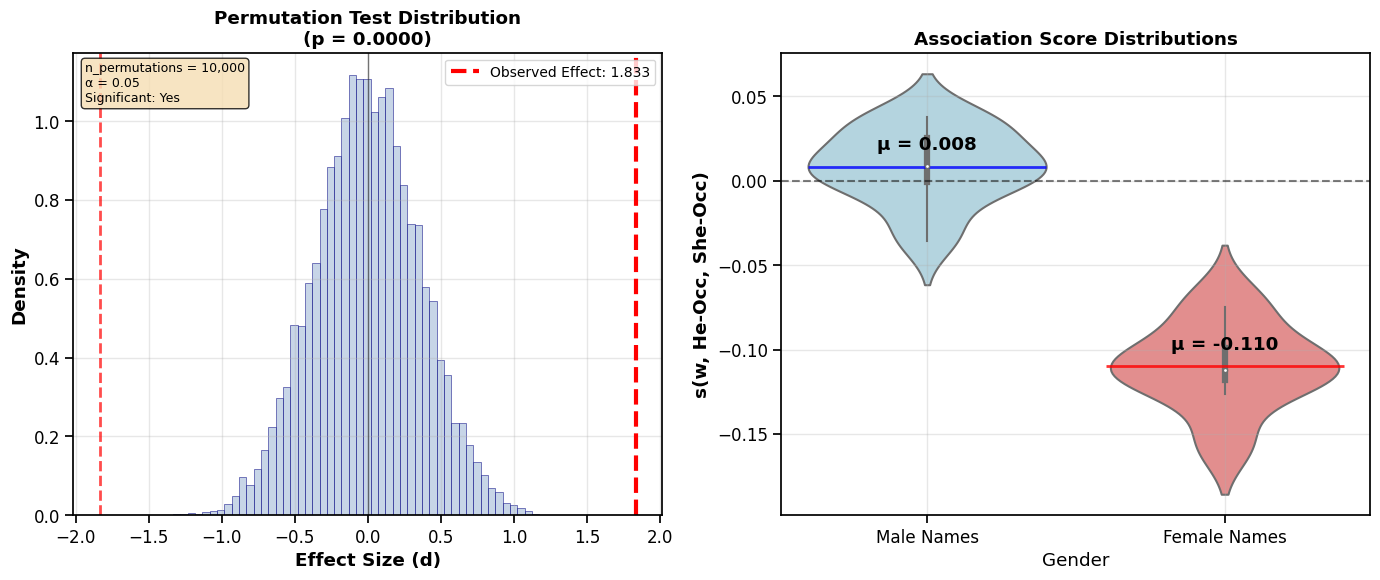

In [ ]:
plot_weat_permutation_results(results["weat_results"])    

Plot 1: Permutation Test Distribution
Shows the "null hypothesis" world where gender names have no systematic association with occupation types. The red line at 1.833 is so far outside this distribution that it never occurred in 10,000 random trials, proving the bias is real and not due to chance.

Plot 2: Association Score Distributions
Reveals the actual pattern: female names cluster strongly toward "she" occupations (negative scores), while male names are more neutral. This asymmetry suggests feminine occupational stereotypes are more deeply embedded than masculine ones.

2. Analysing Personality Trait Association

In [ ]:
# Personality traits associated with competence/agency (traditionally male-associated)
competence_traits = [
    'brilliant', 'genius', 'intelligent', 'smart', 'clever', 'logical',
    'analytical', 'rational', 'strategic', 'decisive', 'assertive', 
    'confident', 'ambitious', 'competitive', 'independent'
]

# Personality traits associated with warmth/communality (traditionally female-associated)
warmth_traits = [
    'nurturing', 'caring', 'compassionate', 'empathetic', 'kind',
    'gentle', 'sensitive', 'emotional', 'supportive', 'understanding',
    'cooperative', 'helpful', 'friendly', 'warm', 'affectionate'
]

def run_personality_weat(model):
    male_vecs = get_word_vectors(model, male_names)
    female_vecs = get_word_vectors(model, female_names)
    competence_vecs = get_word_vectors(model, competence_traits)
    warmth_vecs = get_word_vectors(model, warmth_traits)
    
    print("WEAT Test: Male/Female Names × Competence/Warmth Traits")
    print("H0: No association between gender names and personality trait types")
    print("H1: Male names more associated with competence, female names with warmth\n")
    
    effect_size, p_value, permuted_effects, male_assoc, female_assoc = weat_permutation_test(
        male_vecs, female_vecs, competence_vecs, warmth_vecs
    )
    
    print(f"Effect Size (d): {effect_size:.4f}")
    print(f"P-value: {p_value:.6f}")
    print(f"Statistical significance: {'Yes' if p_value < 0.05 else 'No'} (α = 0.05)")
    
    # Cohen's d interpretation
    if abs(effect_size) < 0.2:
        magnitude = "negligible"
    elif abs(effect_size) < 0.5:
        magnitude = "small"
    elif abs(effect_size) < 0.8:
        magnitude = "medium"
    else:
        magnitude = "large"
    
    print(f"Effect size magnitude: {magnitude}")
    
    # Interpretation
    if effect_size > 0:
        print(f"\nResult: Male names are more associated with competence traits")
        print(f"        Female names are more associated with warmth traits")
        print(f"        → Confirms personality gender stereotypes in embeddings")
    else:
        print(f"\nResult: Female names are more associated with competence traits")
        print(f"        Male names are more associated with warmth traits")
        print(f"        → Counter-stereotypical associations found")
    
    return {
        'effect_size': effect_size,
        'p_value': p_value,
        'permuted_effects': permuted_effects,
        'male_associations': male_assoc,
        'female_associations': female_assoc,
    }

In [59]:
def run_personality_weat_analysis(model):
    weat_results = run_personality_weat(model)
    return {
        'weat_results': weat_results
    }
results = run_personality_weat_analysis(model)

WEAT Test: Male/Female Names × Competence/Warmth Traits
H0: No association between gender names and personality trait types
H1: Male names more associated with competence, female names with warmth

Effect Size (d): 1.1075
P-value: 0.001200
Statistical significance: Yes (α = 0.05)
Effect size magnitude: large

Result: Male names are more associated with competence traits
        Female names are more associated with warmth traits
        → Confirms personality gender stereotypes in embeddings


In [60]:
def plot_personality_weat_results(weat_results):  
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('WEAT Analysis: Personality Gender Stereotypes', fontsize=16, fontweight='bold')

    permuted_effects = weat_results['permuted_effects']
    observed_effect = weat_results['effect_size']
    p_value = weat_results['p_value']

    ax1 = axes[0]
    n, bins, patches = ax1.hist(permuted_effects, bins=50, alpha=0.7, color='lightsteelblue',
                                edgecolor='navy', linewidth=0.5, density=True)

    for i, patch in enumerate(patches):
        if bins[i] <= -abs(observed_effect) or bins[i] >= abs(observed_effect):
            patch.set_facecolor('lightcoral')
            patch.set_alpha(0.8)

    ax1.axvline(observed_effect, color='red', linestyle='--', linewidth=3,
                label=f'Observed Effect: {observed_effect:.3f}')
    ax1.axvline(-observed_effect, color='red', linestyle='--', linewidth=2, alpha=0.7)
    ax1.axvline(0, color='black', linestyle='-', alpha=0.5, linewidth=1)

    ax1.set_xlabel('Effect Size (d)', fontweight='bold')
    ax1.set_ylabel('Density', fontweight='bold')
    ax1.set_title(f'Permutation Test Distribution\n(p = {p_value:.4f})', fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)

    textstr = f'n_permutations = {len(permuted_effects):,}\nα = 0.05\n'
    textstr += f'Significant: {"Yes" if p_value < 0.05 else "No"}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    ax1.text(0.02, 0.98, textstr, transform=ax1.transAxes, fontsize=9,
             verticalalignment='top', bbox=props)


    ax2 = axes[1]
    male_assoc = weat_results['male_associations']
    female_assoc = weat_results['female_associations']

    data_for_violin = pd.DataFrame({
        'Association Score': male_assoc + female_assoc,
        'Gender': ['Male Names'] * len(male_assoc) + ['Female Names'] * len(female_assoc)
    })

    sns.violinplot(data=data_for_violin, x='Gender', y='Association Score', ax=ax2,
                   palette=['lightblue', 'lightcoral'], inner='box')
    ax2.axhline(0, color='black', linestyle='--', alpha=0.5)
    ax2.set_title('Association Score Distributions', fontweight='bold')
    ax2.set_ylabel('s(w, Competence, Warmth)', fontweight='bold')
    ax2.grid(True, alpha=0.3)

    # Add mean lines
    male_mean = np.mean(male_assoc)
    female_mean = np.mean(female_assoc)
    ax2.hlines(male_mean, -0.4, 0.4, colors='blue', linestyles='solid', linewidth=2, alpha=0.8)
    ax2.hlines(female_mean, 0.6, 1.4, colors='red', linestyles='solid', linewidth=2, alpha=0.8)
    ax2.text(0, male_mean + 0.01, f'μ = {male_mean:.3f}', ha='center', fontweight='bold')
    ax2.text(1, female_mean + 0.01, f'μ = {female_mean:.3f}', ha='center', fontweight='bold')

    plt.tight_layout()
    plt.show()

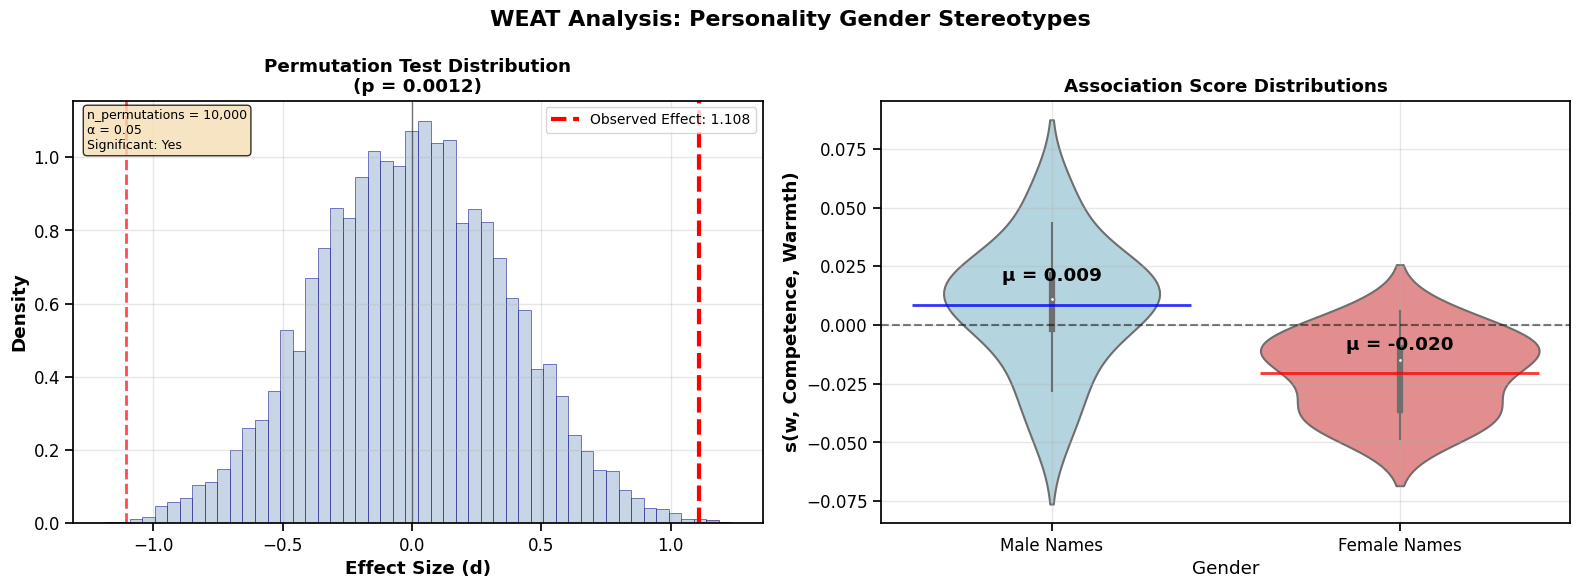

In [61]:
plot_personality_weat_results(results["weat_results"])

This WEAT analysis reveals statistically significant personality gender stereotypes in Word2Vec embeddings (p = 0.0012, d = 1.108). The effect size of 1.108 represents a large bias magnitude, indicating that the model has systematically learned traditional gender-personality associations.

The violin plots show the underlying pattern: male names show slight positive association with competence traits (μ = 0.009), while female names demonstrate stronger negative association (μ = -0.020), meaning they associate more strongly with warmth traits like caring, nurturing, and empathetic rather than competence traits like brilliant, genius, and logical.

This confirms that Word2Vec has encoded the psychological stereotype where masculinity is linked to agency/competence and femininity to communality/warmth - a bias that could perpetuate harmful stereotypes in downstream NLP applications.

In [ ]:
# =======================
# CONTINUATION: WEAT (complete)
# =======================
import numpy as np
import pandas as pd
from collections import OrderedDict
from tqdm import tqdm
from scipy.stats import norm
import matplotlib.pyplot as plt
import os
import random

# -------------------------------------------------
# 1) If you didn't already, wrap your embeddings
# -------------------------------------------------
try:
    EMBEDS
except NameError:
    try:
        EMBEDS = {"embedding": kv}  # if you only have `kv`
    except NameError:
        raise ValueError("Please define EMBEDS = {'name': KeyedVectors(...), ...} or at least `kv`.")

OUT_DIR = "weat_results"
os.makedirs(OUT_DIR, exist_ok=True)
SEED = 42
N_PERMUTATIONS = 10000
ALPHA = 0.05
random.seed(SEED)
np.random.seed(SEED)

# -------------------------------------------------
# 2) Define the remaining WEAT tests (Caliskan et al., 2017)
#    (Add/remove as you need; IDs are conventional WEAT #s)
# -------------------------------------------------
# Male/Female names
male_names = ["John", "Paul", "Mike", "Kevin", "Steve", "Greg", "Jeff", "Bill", "Frank", "George"]
female_names = ["Amy", "Joan", "Lisa", "Sarah", "Diana", "Kate", "Ann", "Donna", "Susan", "Carol"]

# Male/Female terms
male_terms = ["male", "man", "boy", "brother", "he", "him", "his", "son"]
female_terms = ["female", "woman", "girl", "sister", "she", "her", "hers", "daughter"]

# Career/Family
career_words = ["executive", "management", "professional", "corporation", "salary", "office", "business", "career"]
family_words = ["home", "parents", "children", "family", "cousins", "marriage", "wedding", "relatives"]

# Science/Arts
science_words = ["science", "technology", "physics", "chemistry", "Einstein", "NASA", "experiment", "astronomy"]
arts_words    = ["poetry", "art", "Shakespeare", "dance", "literature", "novel", "symphony", "drama"]

# Math/Arts
math_words = ["math", "algebra", "geometry", "calculus", "equations", "computation", "numbers", "theorem"]

WEAT_TESTS = OrderedDict({
    # WEAT 6 (Caliskan): Male vs Female names; Career vs Family
    "WEAT6_gender_names__career_family": {
        "X": male_names,
        "Y": female_names,
        "A": career_words,
        "B": family_words
    },
    # WEAT 7 (Caliskan): Science vs Arts; Male vs Female terms
    "WEAT7_science_arts__male_female_terms": {
        "X": science_words,
        "Y": arts_words,
        "A": male_terms,
        "B": female_terms
    },
    # WEAT 8 (Caliskan): Math vs Arts; Male vs Female terms
    "WEAT8_math_arts__male_female_terms": {
        "X": math_words,
        "Y": arts_words,
        "A": male_terms,
        "B": female_terms
    },
})

# (If you already ran one of these tests in earlier cells, remove or rename it here.)

# -------------------------------------------------
# 3) Core WEAT functions
# -------------------------------------------------
def cosine_sim(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v) + 1e-12)

def weat_effect_size(X, Y, A, B, vecs):
    def s(w):
        return np.mean([cosine_sim(vecs[w], vecs[a]) for a in A]) - \
               np.mean([cosine_sim(vecs[w], vecs[b]) for b in B])
    Xs = np.array([s(x) for x in X])
    Ys = np.array([s(y) for y in Y])
    pooled_std = np.std(np.concatenate([Xs, Ys]), ddof=1)
    d = 0.0 if pooled_std == 0 else (Xs.mean() - Ys.mean()) / pooled_std
    return float(d), Xs, Ys

def permutation_test_weat(X, Y, A, B, vecs, n_perm=10000, seed=42):
    rng = np.random.default_rng(seed)
    d_obs, Xs, Ys = weat_effect_size(X, Y, A, B, vecs)
    concat = np.concatenate([Xs, Ys])
    nX = len(Xs)
    more_extreme = 0
    for _ in range(n_perm):
        rng.shuffle(concat)
        Xp = concat[:nX]
        Yp = concat[nX:]
        pooled_std = np.std(concat, ddof=1)
        d_perm = 0.0 if pooled_std == 0 else (Xp.mean() - Yp.mean()) / pooled_std
        if abs(d_perm) >= abs(d_obs):
            more_extreme += 1
    p = (more_extreme + 1) / (n_perm + 1)
    return float(d_obs), float(p), int(n_perm)

def holm_bonferroni(pvals_dict, alpha=0.05):
    """
    pvals_dict: {hypothesis_name: p_raw}
    returns: {hypothesis_name: {"p_raw":..., "p_holm":..., "reject": True/False}}
    """
    items = sorted(pvals_dict.items(), key=lambda x: x[1])
    m = len(items)
    out = {}
    for i, (name, p) in enumerate(items, 1):
        threshold = alpha / (m - i + 1)
        reject = p <= threshold
        out[name] = {"p_raw": p, "p_holm": min(1.0, p * (m - i + 1)), "reject": reject}
    # restore input order
    return {k: out[k] for k in pvals_dict.keys()}

# -------------------------------------------------
# 4) Run WEAT over all embeddings & tests
# -------------------------------------------------
rows = []
pvals = {}

for emb_name, kv in EMBEDS.items():
    print(f"\n>>> Embedding: {emb_name}")
    for test_name, test in WEAT_TESTS.items():
        X = [w for w in test["X"] if w.lower() in kv or w in kv]
        Y = [w for w in test["Y"] if w.lower() in kv or w in kv]
        A = [w for w in test["A"] if w.lower() in kv or w in kv]
        B = [w for w in test["B"] if w.lower() in kv or w in kv]

        # build a vecs dict (lowercase fallback)
        def get_vec(w):
            lw = w.lower()
            if lw in kv:
                return kv[lw]
            if w in kv:
                return kv[w]
            return None
        words_ok = set(X + Y + A + B)
        vecs = {w: get_vec(w) for w in words_ok if get_vec(w) is not None}

        # re-filter with only words we found
        X = [w for w in X if w in vecs]
        Y = [w for w in Y if w in vecs]
        A = [w for w in A if w in vecs]
        B = [w for w in B if w in vecs]

        if not (len(X) and len(Y) and len(A) and len(B)):
            print(f"Skipping {test_name}: some word sets empty after filtering.")
            continue

        d, p, n_perm = permutation_test_weat(X, Y, A, B, vecs, n_perm=N_PERMUTATIONS, seed=SEED)
        rows.append({
            "embedding": emb_name,
            "test": test_name,
            "weat_d": d,
            "p_value": p,
            "n_perm": n_perm,
            "n_X": len(X), "n_Y": len(Y), "n_A": len(A), "n_B": len(B)
        })
        pvals[f"{emb_name}::{test_name}"] = p

df = pd.DataFrame(rows)
df.to_csv(os.path.join(OUT_DIR, "weat_results_raw.csv"), index=False)
print("\nRaw WEAT results:")
display(df)

# -------------------------------------------------
# 5) Holm–Bonferroni correction
# -------------------------------------------------
holm = holm_bonferroni(pvals, alpha=ALPHA)
holm_rows = []
for hyp, v in holm.items():
    emb, test = hyp.split("::")
    holm_rows.append({
        "embedding": emb,
        "test": test,
        "p_raw": v["p_raw"],
        "p_holm": v["p_holm"],
        f"reject_{ALPHA}": v["reject"]
    })
df_holm = pd.DataFrame(holm_rows)

df_merged = (
    df.merge(df_holm, on=["embedding", "test"], how="left")
      .sort_values(["embedding", "test"])
)
df_merged.to_csv(os.path.join(OUT_DIR, "weat_results_holm.csv"), index=False)

print("\nHolm–Bonferroni corrected results:")
display(df_merged)

# -------------------------------------------------
# 6) Quick bar plot (effect sizes by test)
# -------------------------------------------------
plt.figure(figsize=(8, 4))
for emb_name in df_merged["embedding"].unique():
    sub = df_merged[df_merged["embedding"] == emb_name]
    plt.bar(np.arange(len(sub)) + (0.35 if emb_name != df_merged["embedding"].unique()[0] else 0),
            sub["weat_d"], width=0.35, label=emb_name)
plt.axhline(0, color='black', linewidth=1)
plt.xticks(np.arange(len(sub)), sub["test"], rotation=25, ha='right')
plt.ylabel("WEAT effect size (Cohen's d)")
plt.title("WEAT effect sizes across tests/embeddings")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "weat_effect_sizes.png"), dpi=200)
plt.show()

print(f"\n✅ Saved to: {OUT_DIR}")


Conclusion
